In [14]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [15]:
class Encoder(nn.Module):
    def __init__(self,dim_x,dim_w) -> None:
        super().__init__()
        self.network=nn.Sequential(nn.Linear(784,200),nn.LayerNorm(200),nn.GELU(),nn.Linear(200,100),nn.LayerNorm(100),nn.GELU())
        self.infer_w=nn.Linear(100,dim_w*2)
        self.infer_x=nn.Linear(100,dim_x*2)
    def forward(self,inp):
        inp=self.network(inp)
        return (torch.chunk(self.infer_w(inp),2,dim=-1),torch.chunk(self.infer_x(inp),2,dim=-1))

class Decoder(nn.Module):
    def __init__(self,dim_x) -> None:
        super().__init__()
        self.network=nn.Sequential(nn.Linear(dim_x,100),nn.LayerNorm(100),nn.GELU(),nn.Linear(100,200),nn.LayerNorm(200),nn.GELU(),nn.Linear(200,784))
    
    def forward(self,x):
        return self.network(x)
    
    def log_prob(self,x,y):
        xp=self.network(x)
        return F.binary_cross_entropy_with_logits(xp,y,reduction="none")
    
def log_like_gaussian(mean,std,point):
    return torch.sum(-(point-mean)**2/(2*std**2),dim=-1)

def KL_gaussian(mu_1,sigma_1_log,mu_2,sigma_2_log):
    return torch.sum(-sigma_1_log+sigma_2_log+(torch.exp(2*sigma_1_log)+(mu_1-mu_2)**2)/(2*torch.exp(sigma_2_log*2))-1/2,dim=-1)

def KL_categorical(probs_1,probs_2):
    return torch.sum(probs_1*(torch.log(probs_1+1e-5)-torch.log(probs_2+1e-5)),dim=0)

class GMVAE(nn.Module):
    def __init__(self,dim_x,dim_w,K) -> None:
        super().__init__()
        self.encoder=Encoder(dim_x,dim_w)
        self.GMM=nn.Sequential(nn.Linear(dim_w,500),nn.GELU(),nn.Linear(500,2*K*dim_x))
        self.decoder=Decoder(dim_x)
        self.K=K
        self.dim_x=dim_x
        self.dim_w=dim_w

    def forward(self,y,M):
        batch=y.shape[0]
        ((w_mu,w_sigma_log),(x_mu,x_sigma_log))=self.encoder(y)
        x=torch.randn([M,*x_mu.shape]).to(x_mu.device)*torch.exp(x_sigma_log)+x_mu
        w=torch.randn([M,*w_mu.shape]).to(x_mu.device)*torch.exp(w_sigma_log)+w_mu
        means,log_std=torch.chunk(self.GMM(w).reshape(self.K,M,batch,self.dim_x,2),2,dim=4)
        log_std=log_std.squeeze(-1)
        std=torch.exp(log_std)
        means=means.squeeze(-1)
        log_probs=log_like_gaussian(means,std,x)
        z_posterior=F.softmax(log_probs,dim=0)
        KL_w_prior=KL_gaussian(w_mu,w_sigma_log,torch.zeros_like(w_mu),torch.zeros_like(w_sigma_log))
        KL_z_prior=KL_categorical(torch.ones_like(z_posterior)/self.K,z_posterior)
        conditional_prior=torch.sum(z_posterior*KL_gaussian(x_mu,x_sigma_log,means,log_std),dim=0)
        rec_los=torch.sum(self.decoder.log_prob(x,y.unsqueeze(0).expand(M,*y.shape)),axis=-1)
        return torch.mean(rec_los+KL_w_prior+KL_z_prior+conditional_prior,axis=0)
    
    def latent(self,y):
        ((w_mu,w_sigma_log),(x_mu,x_sigma_log))=self.encoder(y)
        return x_mu
    
    def predict(self,y):
        ((w_mu,w_sigma_log),(x_mu,x_sigma_log))=self.encoder(y)
        x=torch.rand_like(x_mu)*torch.exp(x_sigma_log)+x_mu
        return torch.sigmoid(self.decoder(x))

In [16]:
model=GMVAE(200,150,10)
optim=torch.optim.Adam(model.parameters(),lr=0.0005)
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),])
device="cuda"
model=model.to(device)
M=10

In [17]:
data=torchvision.datasets.MNIST(".",download=True,transform=transform)
data_test=torchvision.datasets.MNIST(".",download=True,transform=transform,train=False)

In [18]:
data_loader=DataLoader(data,128,True)
data_loader_test=DataLoader(data_test,128,True)

In [19]:
for num in range(20):
    loss_ep=0
    loss_test=0
    model.train()
    for X,Y in tqdm(data_loader,"training"):
        optim.zero_grad()
        X=X.to(device).reshape(X.shape[0],784)
        #print(torch.max(X))
        loss=torch.sum(model(X,M))
        #print(loss.item())
        loss.backward()
        optim.step()
        loss_ep+=loss.item()/len(data)
    model.eval()
    for X,Y in tqdm(data_loader_test,"evaluation"):
        X=X.to(device).reshape(X.shape[0],784)
        loss=torch.sum(model(X,M))
        loss_test+=loss.item()/len(data_test)
    print("epoche: {0:.0f},loss: {1:.2f}, test loss: {2:.2f}".format(num,loss_ep,loss_test))


training:   0%|          | 0/469 [00:00<?, ?it/s]

evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

epoche: 0,loss: 228.85, test loss: 206.37


training:   0%|          | 0/469 [00:00<?, ?it/s]

evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

epoche: 1,loss: 206.27, test loss: 201.03


training:   0%|          | 0/469 [00:00<?, ?it/s]

evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

epoche: 2,loss: 190.61, test loss: 177.42


training:   0%|          | 0/469 [00:00<?, ?it/s]

evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

epoche: 3,loss: 163.84, test loss: 148.32


training:   0%|          | 0/469 [00:00<?, ?it/s]

evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

epoche: 4,loss: 139.72, test loss: 132.63


training:   0%|          | 0/469 [00:00<?, ?it/s]

evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

epoche: 5,loss: 129.27, test loss: 125.12


training:   0%|          | 0/469 [00:00<?, ?it/s]

evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

epoche: 6,loss: 123.33, test loss: 119.67


training:   0%|          | 0/469 [00:00<?, ?it/s]

evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

epoche: 7,loss: 118.61, test loss: 116.42


training:   0%|          | 0/469 [00:00<?, ?it/s]

evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

epoche: 8,loss: 115.96, test loss: 114.14


training:   0%|          | 0/469 [00:00<?, ?it/s]

evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

epoche: 9,loss: 114.01, test loss: 112.52


training:   0%|          | 0/469 [00:00<?, ?it/s]

evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

epoche: 10,loss: 112.38, test loss: 111.18


training:   0%|          | 0/469 [00:00<?, ?it/s]

evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

epoche: 11,loss: 111.08, test loss: 110.00


training:   0%|          | 0/469 [00:00<?, ?it/s]

evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

epoche: 12,loss: 109.79, test loss: 108.78


training:   0%|          | 0/469 [00:00<?, ?it/s]

evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

epoche: 13,loss: 108.38, test loss: 107.49


training:   0%|          | 0/469 [00:00<?, ?it/s]

evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

epoche: 14,loss: 107.37, test loss: 106.83


training:   0%|          | 0/469 [00:00<?, ?it/s]

evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

epoche: 15,loss: 106.73, test loss: 106.28


training:   0%|          | 0/469 [00:00<?, ?it/s]

evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

epoche: 16,loss: 106.19, test loss: 105.79


training:   0%|          | 0/469 [00:00<?, ?it/s]

evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

epoche: 17,loss: 105.72, test loss: 105.35


training:   0%|          | 0/469 [00:00<?, ?it/s]

evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

epoche: 18,loss: 105.29, test loss: 105.14


training:   0%|          | 0/469 [00:00<?, ?it/s]

evaluation:   0%|          | 0/79 [00:00<?, ?it/s]

epoche: 19,loss: 104.90, test loss: 104.79


In [20]:
test_data=torch.stack(list(map(lambda x:data_test[x][0],range(0,len(data_test)))))
colors=list(map(lambda x:data_test[x][1],range(0,len(data_test))))
test_data=test_data.squeeze(1).to(device).reshape(test_data.shape[0],784)
model.eval()
latent=model.latent(test_data).cpu().detach().numpy()

In [21]:
tsne=TSNE()
new=tsne.fit_transform(latent)

/home/wesenheit/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/wesenheit/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


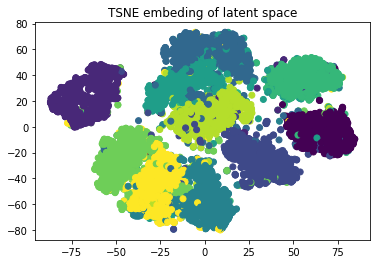

In [22]:
plt.scatter(new[:,0],new[:,1],c=colors);
plt.title("TSNE embeding of latent space");

In [30]:
y=model.predict(data[0][0].cuda().flatten()).reshape(-1,28,28).detach().cpu().numpy()

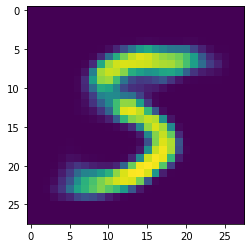

In [31]:
plt.imshow(y[0])